In [1]:
# Curating organoids cell types and projection with in vivo data
import anndata, numpy as np, pandas as pd, imp, lpy, scanpy as sc
sc.logging.print_header()
%load_ext rpy2.ipython
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)


scanpy==1.6.0 anndata==0.7.5 umap==0.3.10 numpy==1.18.1 scipy==1.5.4 pandas==1.0.1 scikit-learn==0.22.2 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.3


In [2]:
adata = anndata.read_h5ad("N2-nuclei.h5ad")

In [3]:
# split endothelial and PV cluster based on umap coordinates, and curate the clusters
annotation = np.array(adata.obs["leidenres2_sampl6kg_cc"], dtype="object")
annotation[(adata.obsm["X_umap_sampl6kg_cc"][:,0] > 3.5) &(adata.obsm["X_umap_sampl6kg_cc"][:,1] > 4.5) & (adata.obs["leidenres2_sampl6kg_cc"] == "20")] = "27"
annotation[(adata.obsm["X_umap_sampl6kg_cc"][:,0] > 10.25) &(adata.obsm["X_umap_sampl6kg_cc"][:,1] <6.5)] = "28"
adata.obs["general_celltypes"] =  lpy.applyFactorRename(annotation,{
    tuple(["3","11"]) : "SOX9 early",
    "13" : "SOX9 late",
    "19": "Lyphoid", # "0": "Endothelial ACKR1",
    "21": "Myeloid",
    "26": "Mast cells",
    "25": "B cells",
    "16": "Endothelial ACKR1", # split?  SEMA3G"0": "Endothelial ACKR1",
    "28": "Endothelial SEMA3G", # split?  SEMA3G"0": "Endothelial ACKR1",
    "22": "Lymphatic",
    "20": "PV STEAP4", # split
    "27": "PV MYH11", # split
    "0" : "uSMC",
    "7": "Fibroblast",
    tuple(["1","2","4", "5","6",  "8", "9","10", "12", "14", "15", "17"]) : "eS",
    tuple(["18", "24"]): "doublets",
    "23": "Low QC"
    }, doinspect=True)
adata.uns["general_celltypes_colors"] = ["#F08129", "#E53215", "#8B4F9A", "#499ABA", '#454C25',  '#DFC6E0', '#48B750' , "#274e13", "#91D625", '#7C7C7C', '#C4C4C2', '#A7A7CE', '#776747', '#A58A62', '#8888FF', '#888888', '#888888']
adata.obs["general_celltypes"].value_counts()

Rename classes in list
def applyFactorRename(input, dico, doinspect = False):
    if doinspect is True: print("\033Rename classes in list\033\033"); print(inspect.getsource(applyFactorRename));
    import numpy as np
    tmp = np.array(input, dtype=object)
    out = tmp.copy()
    for k,x in dico.items():
        if isinstance(k, tuple):
            for l in k:
                out[tmp == l] = x
        else:
            out[tmp == k] = x
    leftover_categories = set(out)
    leftover_categories = leftover_categories.difference(set(dico.values()))
    categories = list(dico.values())
    categories = categories + list(leftover_categories)
    return(pd.Categorical(out, categories, ordered=True))



eS                    16878
SOX9 early             3189
uSMC                   2451
Fibroblast             1514
filtered               1422
SOX9 late              1008
doublets                837
Endothelial ACKR1       806
Lyphoid                 462
PV STEAP4               287
Myeloid                 245
Lymphatic               236
Low QC                  235
PV MYH11                133
Endothelial SEMA3G       88
B cells                  79
Mast cells               50
Name: general_celltypes, dtype: int64

In [4]:
imp.reload(lpy)
adata_primary = anndata.read_h5ad("../primary/N6-integrated_donors.h5ad")
res = lpy.doLogisticRegression(adata, adata_primary, "general_celltypes", cell_filter_src = [ x not in ["filtered", "Other"] for x in  adata_primary.obs["general_celltypes"] ], cc_gene_filter_prefix = "",make_circular_coords =True, cosine_coor_softmax_coef = 15.0, genespeficityfraction = 0.5, C_parameter = 0.01, doinspect=True)

Logisitic regression based projection
def doLogisticRegression(adata, adata_ref, annotation_src, annotation_trg = None, annotation_trg_prob = None, cell_filter_trg = None, cell_filter_src = None, regr_max_iter = 10000, use_variable_genes=True, use_variable_genes_within_subset=True,  cc_gene_filter_prefix= None, use_raw_data=True, use_max_normalization=True, do_compute_cosine_distance=True, filtered_label = "filtered", make_circular_coords=False, cosine_coor_softmax_coef= None, logistic_coor_softmax_coef = None, C_parameter = 1, genespeficityfraction=None, doinspect=False):
    """Compute Logistic regression based projection

    Parameters
    ----------
    adata : Annadata.anndata
        Object containing the cells that are projected
    adata_ref: Annadata.anndata
        Object containing the reference cells that are defining classes used for the projection
    annotation_src : string
        must be in adata_ref.obs.keys(), annotation to project
    annotation_trg : string, optio

In [5]:
#set color for clusters and rename some annotations
adata.write_h5ad("N3-nuclei.h5ad")

Trying to set attribute `.obs` of view, copying.


                     0
0           SOX9 early
1            SOX9 late
2                 uSMC
3             PV MYH11
4            PV STEAP4
5           Fibroblast
6                   eS
7   Endothelial SEMA3G
8    Endothelial ACKR1
9            Lymphatic
10             Lyphoid
11             B cells
12             Myeloid
13          Mast cells


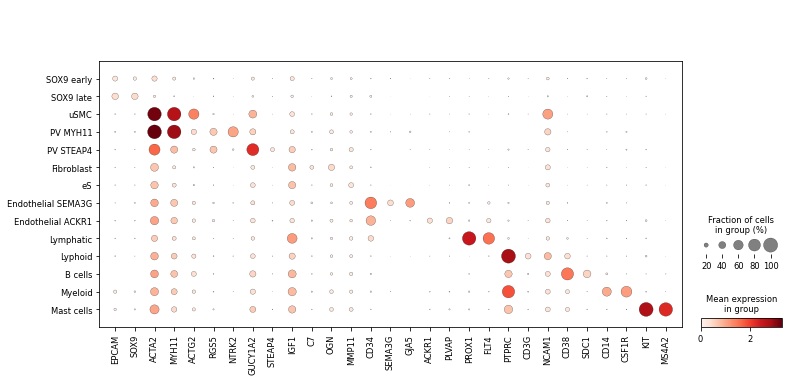

In [6]:
markergenes = ["EPCAM","SOX9","ACTA2", "MYH11","ACTG2","RGS5", "NTRK2","GUCY1A2", "STEAP4", "IGF1","C7", "OGN","MMP11","CD34","SEMA3G", "GJA5","ACKR1", "PLVAP","PROX1", "FLT4","PTPRC","CD3G", "NCAM1","CD38", "SDC1","CD14", "CSF1R","KIT", "MS4A2"]
adata2 = adata[ [x not in ["filtered" , "doublets" , "Low QC"] for x in adata.obs["general_celltypes"] ] ]

adata2.obs["general_celltypes"] = lpy.reorderCat(adata2.obs["general_celltypes"], [0,1,11,10,9,12,13,7,6,8,2,5,3,4])
sc.pl.dotplot(adata2, var_names= markergenes, groupby= "general_celltypes", show=True, use_raw=False, save = "markers_general.pdf")